### Libraries and functions

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from BorutaShap import BorutaShap
from powershap  import PowerShap
import shapicant
from tqdm import tqdm
from SHAPEffects import FeatureSelector
import random
import shap
import os
os.environ['PYTHONHASHSEED'] = str(1234)
random.seed(1234)
np.random.seed(1234)
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Taken from PowerSHAP paper
def scores_calc_print(Y,Y_pred,print_bool):
    if len(Y_pred) > 1:
        R2_total = r2_score(Y,Y_pred)
    else:
        R2_total = -1
    RMSE_total = mean_squared_error(Y,Y_pred, squared=False)
    MAE_total = mean_absolute_error(Y,Y_pred)
    
    if print_bool:
        print(tabulate([[RMSE_total, MAE_total,R2_total]], ["RMSE","MAE","R²"], tablefmt="grid"))
    else:
        return {"R2":R2_total,"RMSE":RMSE_total,"MAE":MAE_total}

### Data

In [3]:
current_db = pd.read_csv(r"Data\Sberbank Russian Housing Market\train.csv")
# macro_db = pd.read_csv(r"Data\Sberbank Russian Housing Market\macro.csv")

In [4]:
current_db

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,30469,2015-06-30,44,27.0,7.0,9.0,1.0,1975.0,2.0,6.0,...,15,5,0,15,26,1,2,84,6,7400000
30467,30470,2015-06-30,86,59.0,3.0,9.0,2.0,1935.0,4.0,10.0,...,313,128,24,98,182,1,82,171,15,25000000
30468,30471,2015-06-30,45,NaN,10.0,20.0,1.0,NaN,1.0,1.0,...,1,1,0,2,12,0,1,11,1,6970959
30469,30472,2015-06-30,64,32.0,5.0,15.0,1.0,2003.0,2.0,11.0,...,22,1,1,6,31,1,4,65,7,13500000


In [5]:
current_db = current_db.dropna()

In [6]:
current_db['timestamp'] = pd.to_datetime(current_db['timestamp'])

In [7]:
current_db

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
8056,8059,2013-05-21,11,11.0,2.0,5.0,2.0,1907.0,1.0,12.0,...,339,135,26,133,207,1,89,161,10,2750000
8154,8157,2013-05-27,45,27.0,6.0,9.0,1.0,1970.0,2.0,6.0,...,2,1,0,3,8,1,0,19,3,7100000
8287,8290,2013-06-03,77,50.0,3.0,5.0,2.0,1957.0,3.0,8.0,...,214,85,21,48,89,1,54,146,12,11700000
8387,8390,2013-06-07,56,29.0,5.0,16.0,5.0,1987.0,2.0,10.0,...,74,32,8,19,34,0,10,121,7,10400000
8391,8394,2013-06-07,31,21.0,5.0,9.0,5.0,1962.0,1.0,5.0,...,99,43,8,17,41,1,18,93,5,6200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30462,30465,2015-06-30,47,30.0,23.0,25.0,4.0,2016.0,1.0,10.0,...,99,57,12,23,42,1,13,123,7,10544070
30463,30466,2015-06-30,56,29.0,13.0,14.0,1.0,2001.0,2.0,11.0,...,14,2,0,13,12,0,1,53,6,12000000
30467,30470,2015-06-30,86,59.0,3.0,9.0,2.0,1935.0,4.0,10.0,...,313,128,24,98,182,1,82,171,15,25000000
30469,30472,2015-06-30,64,32.0,5.0,15.0,1.0,2003.0,2.0,11.0,...,22,1,1,6,31,1,4,65,7,13500000


In [8]:
for f in current_db.columns:
    if current_db[f].dtype=='object':
        print(f)
        lbl = LabelEncoder()
        lbl.fit(list(current_db[f].values.astype('str')))
        current_db[f] = lbl.transform(list(current_db[f].values.astype('str')))

product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology


In [9]:
current_db = current_db.drop('id', axis = 1)

In [10]:
current_db = current_db.reset_index(drop=True)

In [11]:
Index_col = "timestamp"
target_col = "price_doc"

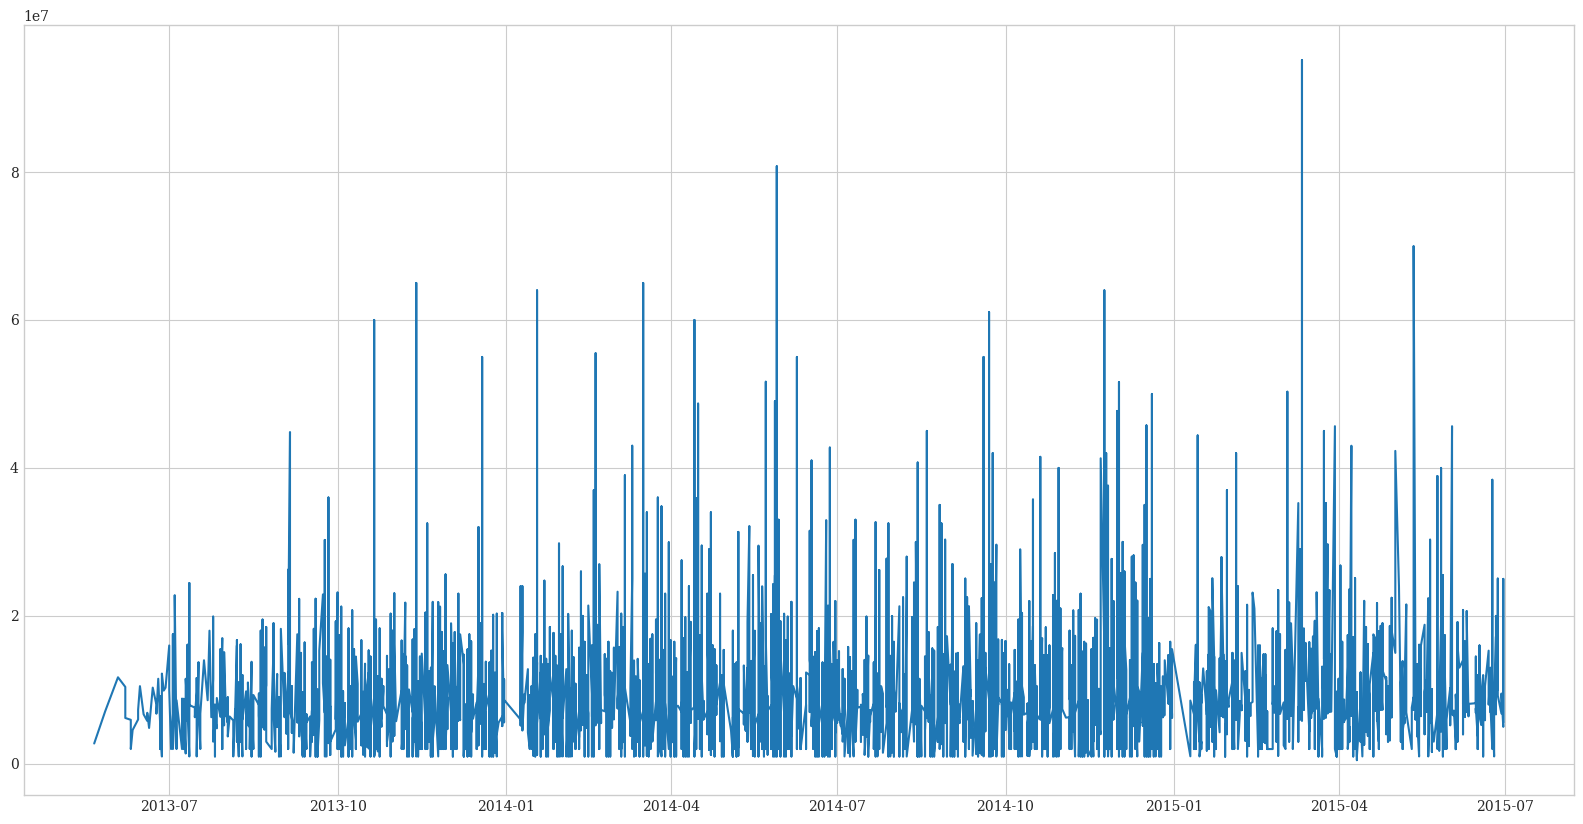

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.plot(current_db.timestamp, current_db.price_doc)

In [13]:
num_test = round(0.8 * len(current_db))
num_test

4834

In [14]:
num_val = num_test - (len(current_db) - num_test)
num_val

3626

In [15]:
current_db_test = current_db.iloc[num_test:]
current_db_train = current_db.iloc[:num_val]
current_db_val = current_db.iloc[num_val:num_test]

train_idx = current_db_train[Index_col].unique()
val_idx = current_db_val[Index_col].unique()
test_idx = current_db_test[Index_col].unique()

In [16]:
len(current_db_train), len(current_db_val), len(current_db_test)

(3626, 1208, 1208)

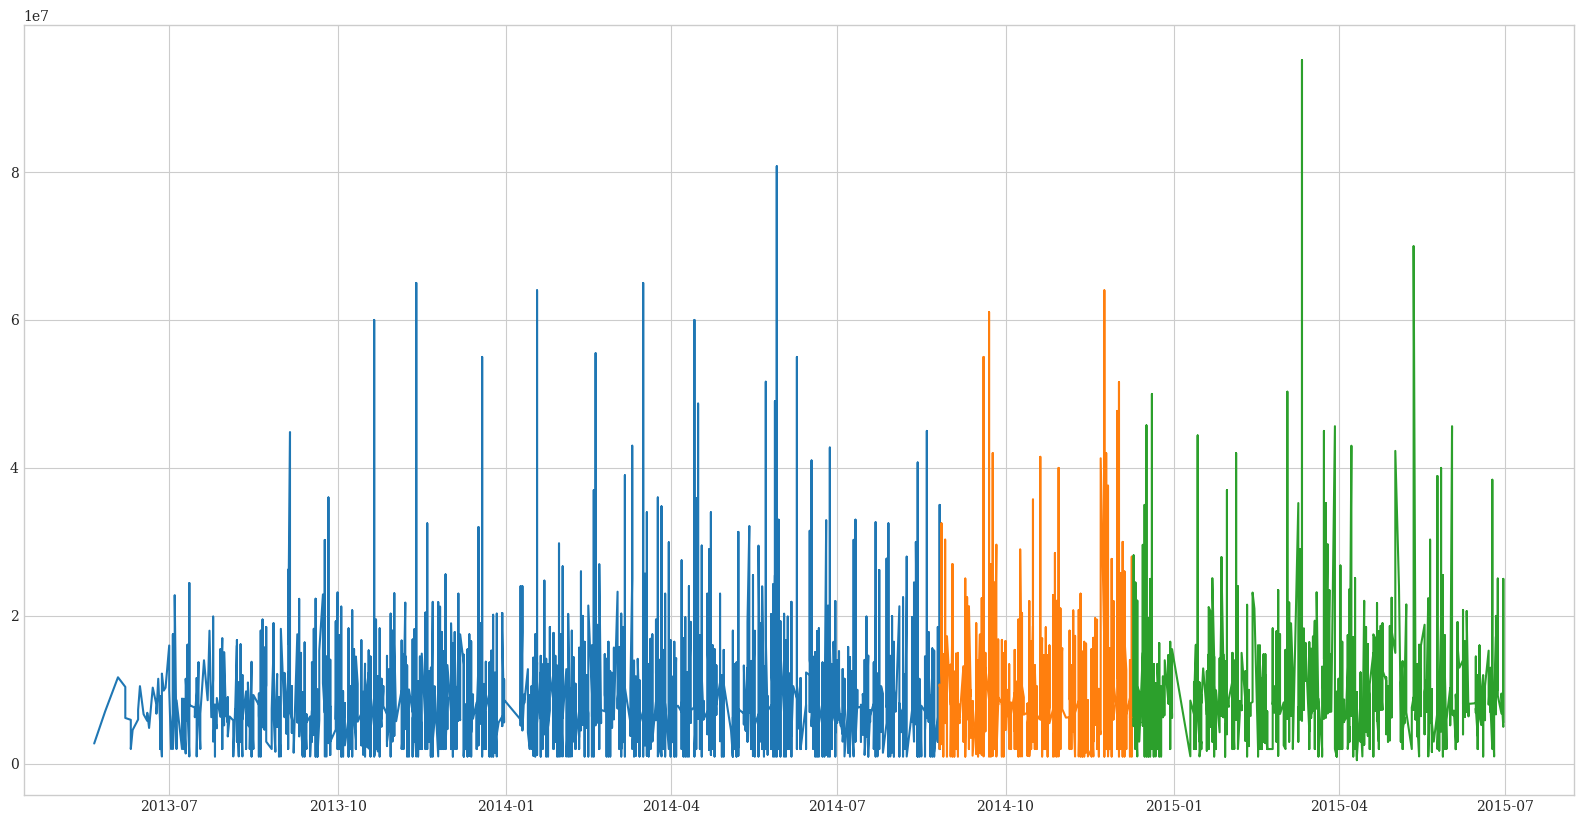

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.plot(current_db_train.timestamp, current_db_train.price_doc)
ax.plot(current_db_val.timestamp, current_db_val.price_doc)
ax.plot(current_db_test.timestamp, current_db_test.price_doc)

In [18]:
selected_columns = list(current_db.columns)
selected_columns.remove('timestamp')
selected_columns.remove('price_doc')

In [19]:
selected_columns

['full_sq',
 'life_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'product_type',
 'sub_area',
 'area_m',
 'raion_popul',
 'green_zone_part',
 'indust_part',
 'children_preschool',
 'preschool_quota',
 'preschool_education_centers_raion',
 'children_school',
 'school_quota',
 'school_education_centers_raion',
 'school_education_centers_top_20_raion',
 'hospital_beds_raion',
 'healthcare_centers_raion',
 'university_top_20_raion',
 'sport_objects_raion',
 'additional_education_raion',
 'culture_objects_top_25',
 'culture_objects_top_25_raion',
 'shopping_centers_raion',
 'office_raion',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'full_all',
 'male_f',
 'female_f',
 'young_all',
 'young_male',
 'young_female',
 'work_all',
 'work_male',
 'work_female',
 'ekder_all',
 'ekder_male',
 'ek

In [20]:
X_train = current_db_train[selected_columns]
y_train = current_db_train[target_col]

X_val = current_db_val[selected_columns]
y_val = current_db_val[target_col]

X_test = current_db_test[selected_columns]
y_test = current_db_test[target_col]

In [21]:
X_train_val = X_train.append(X_val)
y_train_val = y_train.append(y_val)

In [22]:
current_db_train_val = current_db_train.append(current_db_val)

In [23]:
seeds = np.random.randint(1, 999999, 50)

## SHAPEffects 0.75-0.25

In [24]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_075_025 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 0, 0.25, 0.75)
selected_features_shapeffects_075_025 = sorted(list(selected_features_shapeffects_075_025))


Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	54 features have been removed
	 ['area_m', 'raion_popul', 'green_zone_part', 'preschool_education_centers_raion', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'shopping_centers_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'full_all', 'female_f', 'young_male', 'young_female', 'ekder_male', '0_6_male', '7_14_male', '0_17_all', '0_17_male', '16_29_male', '16_29_female', 'build_count_frame', 'build_count_mix', 'big_road1_1line', 'ID_bus_terminal', 'cafe_count_500_price_1500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'church_count_500', 'mosque_count_500', 'market_count_500', 'cafe_count_1000_price_500', 'mosque_count_1000', 'cafe_count_1500_na_price', 'cafe_count_1500_price


Iteration 36
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_count_1500']
	127 features left

Iteration 37
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_count_2000_price_500']
	126 features left

Iteration 38
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_count_1000_price_1000']
	125 features left

Iteration 39
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['sport_count_5000']
	124 features left

Iteration 40
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['park_km']
	123 features left

Iteration 41
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['preschool_km']
	122 features left

Iteration 42
	Clasifying residuals
	Giving weights to feat


Iteration 88
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['railroad_station_walk_min']
	73 features left

Iteration 89
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['green_part_1000']
	72 features left

Iteration 90
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['big_market_km']
	71 features left

Iteration 91
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['trc_count_2000']
	70 features left

Iteration 92
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['catering_km']
	69 features left

Iteration 93
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['railroad_station_avto_km']
	68 features left

Iteration 94
	Clasifying residuals
	Giving weights to features


In [25]:
feat_sel.best_mae

2179211.3335737186

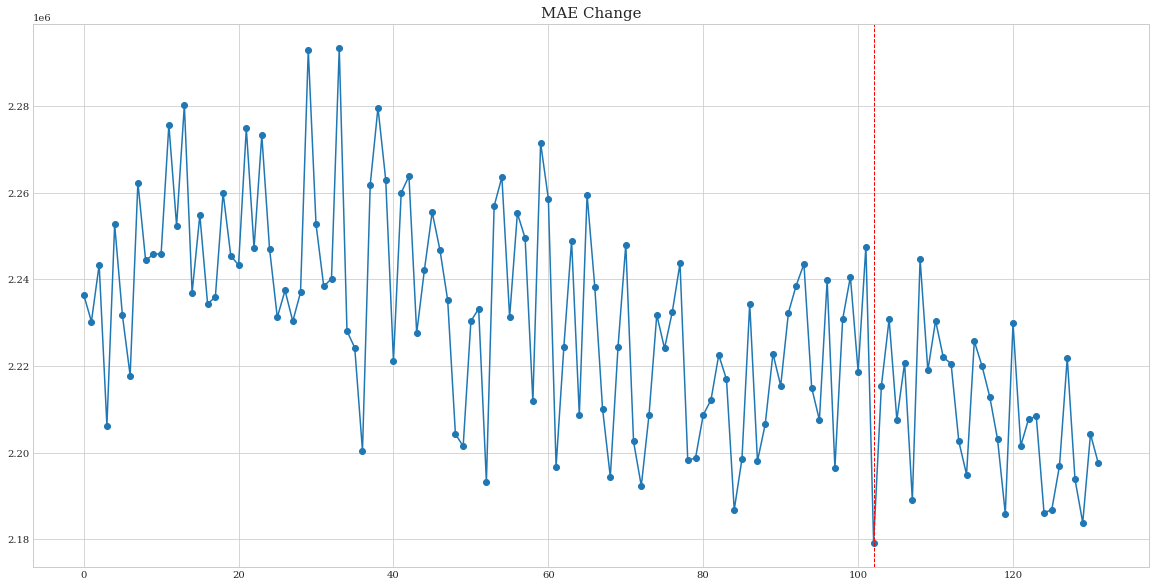

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [27]:
selected_features_shapeffects_075_025

['16_29_all',
 'ID_metro',
 'ID_railroad_station_avto',
 'ID_railroad_station_walk',
 'basketball_km',
 'build_count_brick',
 'build_count_monolith',
 'build_year',
 'bus_terminal_avto_km',
 'cafe_avg_price_1500',
 'cafe_avg_price_2000',
 'cafe_avg_price_500',
 'cafe_avg_price_5000',
 'cafe_count_1000',
 'cafe_count_1000_price_high',
 'cafe_count_3000',
 'cafe_count_5000_price_2500',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1500_min_price_avg',
 'cemetery_km',
 'church_count_1000',
 'church_synagogue_km',
 'exhibition_km',
 'fitness_km',
 'floor',
 'full_sq',
 'green_part_5000',
 'green_zone_km',
 'hospital_beds_raion',
 'incineration_km',
 'kitch_sq',
 'leisure_count_500',
 'life_sq',
 'market_count_3000',
 'max_floor',
 'metro_km_avto',
 'metro_min_avto',
 'metro_min_walk',
 'mosque_km',
 'nuclear_reactor_km',
 'num_room',
 'office_km',
 'office_raion',
 'prom_part_1500',
 'prom_part_2000',
 'prom_part_500',
 'prom_part_5000',
 'public_transport_station_km',
 'public_transport_stat

In [28]:
dict_results_shapeffects_075_025 = {'rmse':[], 'mae':[], 'r2':[]}

In [29]:
X_test_shapeffects = X_test[selected_features_shapeffects_075_025]
X_train_shapeffects= X_train[selected_features_shapeffects_075_025]
X_val_shapeffects = X_val[selected_features_shapeffects_075_025]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_075_025["r2"].append(test_results["R2"])
    dict_results_shapeffects_075_025["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_075_025["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [30]:
results_shapeffects_075_025_df = pd.DataFrame(dict_results_shapeffects_075_025)
mean_shapeffects_075_025_test = results_shapeffects_075_025_df.mean()
std_shapeffects_075_025_test = results_shapeffects_075_025_df.std()
max_shapeffects_075_025_test = results_shapeffects_075_025_df.max()
min_shapeffects_075_025_test = results_shapeffects_075_025_df.min()

In [31]:
mean_shapeffects_075_025_test, std_shapeffects_075_025_test, max_shapeffects_075_025_test, min_shapeffects_075_025_test

(rmse    4.310902e+06
 mae     2.615036e+06
 r2      6.341022e-01
 dtype: float64,
 rmse    85857.954818
 mae     32727.155460
 r2          0.014557
 dtype: float64,
 rmse    4.504829e+06
 mae     2.676788e+06
 r2      6.660812e-01
 dtype: float64,
 rmse    4.119012e+06
 mae     2.517658e+06
 r2      6.005970e-01
 dtype: float64)

## SHAPEffects 0.8-0.2

In [32]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_08_02 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 0, 0.2, 0.8)
selected_features_shapeffects_08_02 = sorted(list(selected_features_shapeffects_08_02))


Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	54 features have been removed
	 ['area_m', 'raion_popul', 'green_zone_part', 'preschool_education_centers_raion', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'shopping_centers_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'full_all', 'female_f', 'young_male', 'young_female', 'ekder_male', '0_6_male', '7_14_male', '0_17_all', '0_17_male', '16_29_male', '16_29_female', 'build_count_frame', 'build_count_mix', 'big_road1_1line', 'ID_bus_terminal', 'cafe_count_500_price_1500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'church_count_500', 'mosque_count_500', 'market_count_500', 'cafe_count_1000_price_500', 'mosque_count_1000', 'cafe_count_1500_na_price', 'cafe_count_1500_price


Iteration 36
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_count_500']
	127 features left

Iteration 37
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['big_road1_km']
	126 features left

Iteration 38
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['7_14_female']
	125 features left

Iteration 39
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['leisure_count_500']
	124 features left

Iteration 40
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_count_1000_price_1000']
	123 features left

Iteration 41
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['preschool_km']
	122 features left

Iteration 42
	Clasifying residuals
	Giving weights to features
	Sel

	Selecting features
	1 features have been removed
	 ['public_healthcare_km']
	75 features left

Iteration 89
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_sum_1000_max_price_avg']
	74 features left

Iteration 90
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['green_part_1000']
	73 features left

Iteration 91
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['radiation_km']
	72 features left

Iteration 92
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['church_count_1000']
	71 features left

Iteration 93
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['green_part_2000']
	70 features left

Iteration 94
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_s

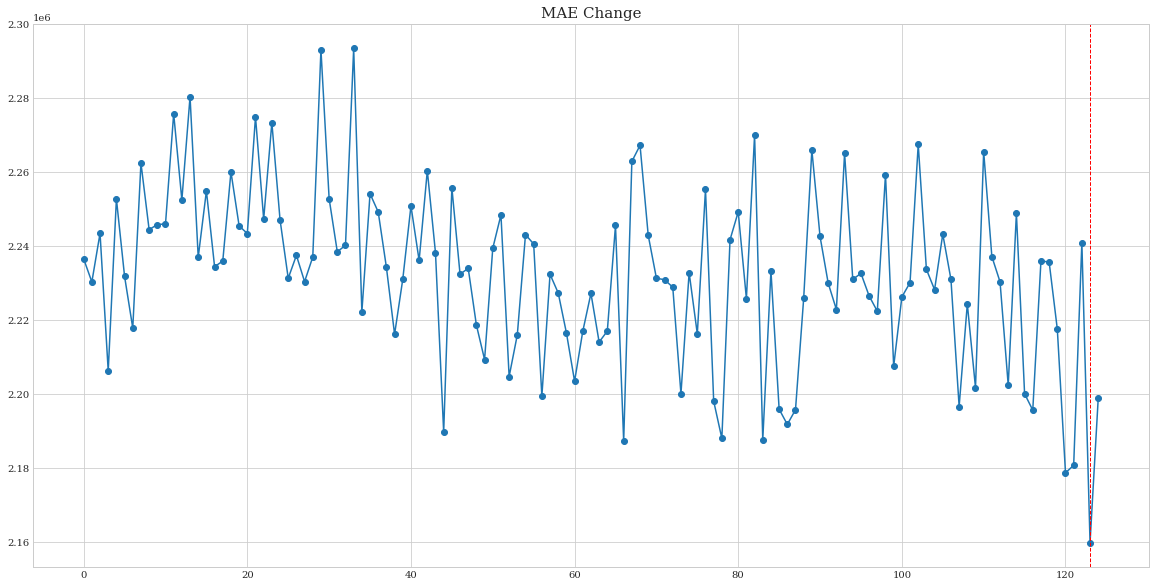

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [34]:
selected_features_shapeffects_08_02

['ID_metro',
 'ID_railroad_station_avto',
 'ID_railroad_station_walk',
 'build_count_brick',
 'build_count_monolith',
 'build_year',
 'cafe_avg_price_1500',
 'cafe_avg_price_2000',
 'cafe_avg_price_5000',
 'cafe_count_1000',
 'cafe_count_1000_price_high',
 'cafe_count_2000',
 'cafe_count_5000_price_1000',
 'cafe_sum_2000_max_price_avg',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_5000_min_price_avg',
 'cemetery_km',
 'church_synagogue_km',
 'floor',
 'full_sq',
 'hospital_beds_raion',
 'ice_rink_km',
 'incineration_km',
 'kindergarten_km',
 'kitch_sq',
 'life_sq',
 'max_floor',
 'metro_min_avto',
 'mosque_km',
 'num_room',
 'prom_part_1000',
 'prom_part_1500',
 'prom_part_5000',
 'state',
 'theater_km',
 'trc_count_2000',
 'trc_sqm_1000',
 'university_km',
 'water_treatment_km']

In [35]:
dict_results_shapeffects_08_02 = {'rmse':[], 'mae':[], 'r2':[]}

In [36]:
X_test_shapeffects = X_test[selected_features_shapeffects_08_02]
X_train_shapeffects= X_train[selected_features_shapeffects_08_02]
X_val_shapeffects = X_val[selected_features_shapeffects_08_02]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_08_02["r2"].append(test_results["R2"])
    dict_results_shapeffects_08_02["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_08_02["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [37]:
results_shapeffects_08_02_df = pd.DataFrame(dict_results_shapeffects_08_02)
mean_shapeffects_08_02_test = results_shapeffects_08_02_df.mean()
std_shapeffects_08_02_test = results_shapeffects_08_02_df.std()
max_shapeffects_08_02_test = results_shapeffects_08_02_df.max()
min_shapeffects_08_02_test = results_shapeffects_08_02_df.min()

In [38]:
mean_shapeffects_08_02_test, std_shapeffects_08_02_test, max_shapeffects_08_02_test, min_shapeffects_08_02_test

(rmse    4.301079e+06
 mae     2.602203e+06
 r2      6.357899e-01
 dtype: float64,
 rmse    78703.603589
 mae     26117.804203
 r2          0.013365
 dtype: float64,
 rmse    4.505593e+06
 mae     2.662229e+06
 r2      6.631885e-01
 dtype: float64,
 rmse    4.136815e+06
 mae     2.556754e+06
 r2      6.004616e-01
 dtype: float64)

## SHAPEffects 0.85-0.15

In [39]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_085_015 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 0, 0.15, 0.85)
selected_features_shapeffects_085_015 = sorted(list(selected_features_shapeffects_085_015))


Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	54 features have been removed
	 ['area_m', 'raion_popul', 'green_zone_part', 'preschool_education_centers_raion', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'shopping_centers_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'full_all', 'female_f', 'young_male', 'young_female', 'ekder_male', '0_6_male', '7_14_male', '0_17_all', '0_17_male', '16_29_male', '16_29_female', 'build_count_frame', 'build_count_mix', 'big_road1_1line', 'ID_bus_terminal', 'cafe_count_500_price_1500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'church_count_500', 'mosque_count_500', 'market_count_500', 'cafe_count_1000_price_500', 'mosque_count_1000', 'cafe_count_1500_na_price', 'cafe_count_1500_price


Iteration 36
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_count_500_price_2500']
	129 features left

Iteration 37
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['office_sqm_1500']
	128 features left

Iteration 38
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_count_2000_price_1500']
	127 features left

Iteration 39
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['ts_km']
	126 features left

Iteration 40
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['church_count_1500']
	125 features left

Iteration 41
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['mkad_km']
	124 features left

Iteration 42
	Clasifying residuals
	Giving weights to features
	

	Selecting features
	1 features have been removed
	 ['cafe_count_5000_price_2500']
	76 features left

Iteration 89
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['bus_terminal_avto_km']
	75 features left

Iteration 90
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['office_count_500']
	74 features left

Iteration 91
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['green_part_3000']
	73 features left

Iteration 92
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['nuclear_reactor_km']
	72 features left

Iteration 93
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['railroad_station_avto_min']
	71 features left

Iteration 94
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been remo

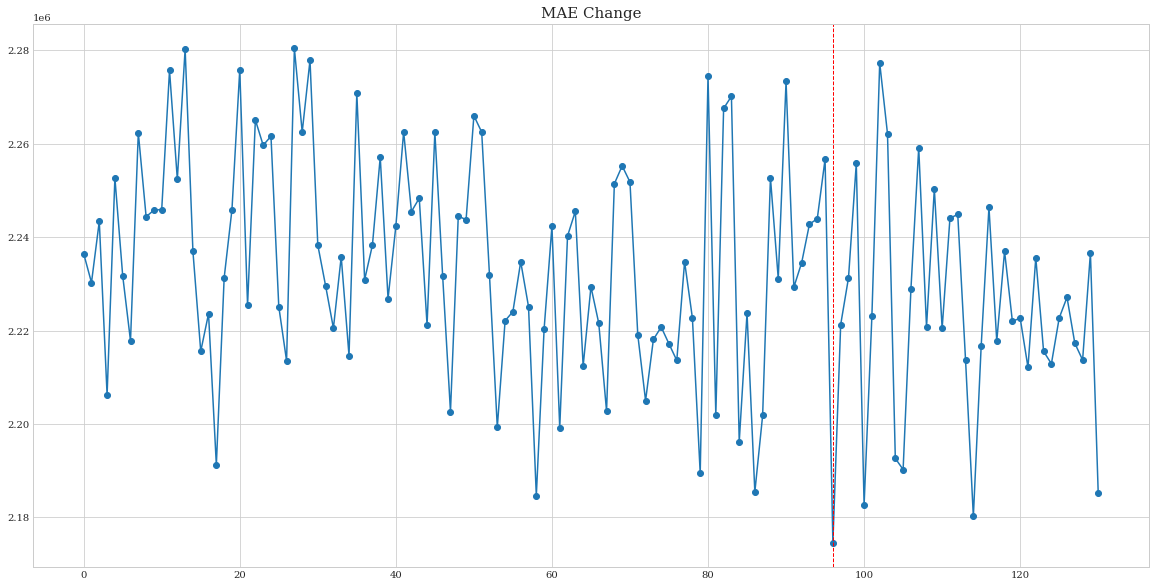

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [41]:
selected_features_shapeffects_085_015

['ID_metro',
 'ID_railroad_station_avto',
 'ID_railroad_station_walk',
 'big_market_km',
 'big_road1_km',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_year',
 'bulvar_ring_km',
 'cafe_avg_price_1500',
 'cafe_avg_price_2000',
 'cafe_count_1000',
 'cafe_count_1500',
 'cafe_count_3000_price_500',
 'cafe_count_5000_price_1500',
 'cafe_count_5000_price_500',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_5000_min_price_avg',
 'catering_km',
 'cemetery_km',
 'church_count_1000',
 'church_synagogue_km',
 'fitness_km',
 'floor',
 'full_sq',
 'green_part_2000',
 'green_part_500',
 'hospital_beds_raion',
 'ice_rink_km',
 'incineration_km',
 'industrial_km',
 'kindergarten_km',
 'kitch_sq',
 'life_sq',
 'market_shop_km',
 'max_floor',
 'metro_min_avto',
 'mosque_km',
 'num_room',
 'product_type',
 'prom_part_1500',
 'prom_part_2000',
 'prom_part_3000',
 'prom_part_500',
 'pr

In [42]:
dict_results_shapeffects_085_015 = {'rmse':[], 'mae':[], 'r2':[]}

In [43]:
X_test_shapeffects = X_test[selected_features_shapeffects_085_015]
X_train_shapeffects= X_train[selected_features_shapeffects_085_015]
X_val_shapeffects = X_val[selected_features_shapeffects_085_015]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_085_015["r2"].append(test_results["R2"])
    dict_results_shapeffects_085_015["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_085_015["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [44]:
results_shapeffects_085_015_df = pd.DataFrame(dict_results_shapeffects_085_015)
mean_shapeffects_085_015_test = results_shapeffects_085_015_df.mean()
std_shapeffects_085_015_test = results_shapeffects_085_015_df.std()
max_shapeffects_085_015_test = results_shapeffects_085_015_df.max()
min_shapeffects_085_015_test = results_shapeffects_085_015_df.min()

In [45]:
mean_shapeffects_085_015_test, std_shapeffects_085_015_test, max_shapeffects_085_015_test, min_shapeffects_085_015_test

(rmse    4.267678e+06
 mae     2.592950e+06
 r2      6.413982e-01
 dtype: float64,
 rmse    86426.456234
 mae     34953.849724
 r2          0.014579
 dtype: float64,
 rmse    4.471832e+06
 mae     2.691641e+06
 r2      6.653886e-01
 dtype: float64,
 rmse    4.123282e+06
 mae     2.524169e+06
 r2      6.064268e-01
 dtype: float64)

## SHAPEffects 0.9-0.1

In [46]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_09_01 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 0, 0.1, 0.9)
selected_features_shapeffects_09_01 = sorted(list(selected_features_shapeffects_09_01))


Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	54 features have been removed
	 ['area_m', 'raion_popul', 'green_zone_part', 'preschool_education_centers_raion', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'shopping_centers_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'full_all', 'female_f', 'young_male', 'young_female', 'ekder_male', '0_6_male', '7_14_male', '0_17_all', '0_17_male', '16_29_male', '16_29_female', 'build_count_frame', 'build_count_mix', 'big_road1_1line', 'ID_bus_terminal', 'cafe_count_500_price_1500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'church_count_500', 'mosque_count_500', 'market_count_500', 'cafe_count_1000_price_500', 'mosque_count_1000', 'cafe_count_1500_na_price', 'cafe_count_1500_price

	Selecting features
	1 features have been removed
	 ['green_part_1500']
	127 features left

Iteration 36
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_count_2000']
	126 features left

Iteration 37
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['office_sqm_1500']
	125 features left

Iteration 38
	Clasifying residuals
	Giving weights to features
	Selecting features
	2 features have been removed
	 ['cafe_avg_price_1000', 'sport_count_1000']
	123 features left

Iteration 39
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_count_500_price_2500']
	122 features left

Iteration 40
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_count_3000_price_4000']
	121 features left

Iteration 41
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 fe

	Selecting features
	1 features have been removed
	 ['railroad_station_avto_min']
	73 features left

Iteration 88
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['public_transport_station_km']
	72 features left

Iteration 89
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['trc_sqm_3000']
	71 features left

Iteration 90
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['ts_km']
	70 features left

Iteration 91
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['ID_railroad_station_walk']
	69 features left

Iteration 92
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_sum_2000_max_price_avg']
	68 features left

Iteration 93
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been remo

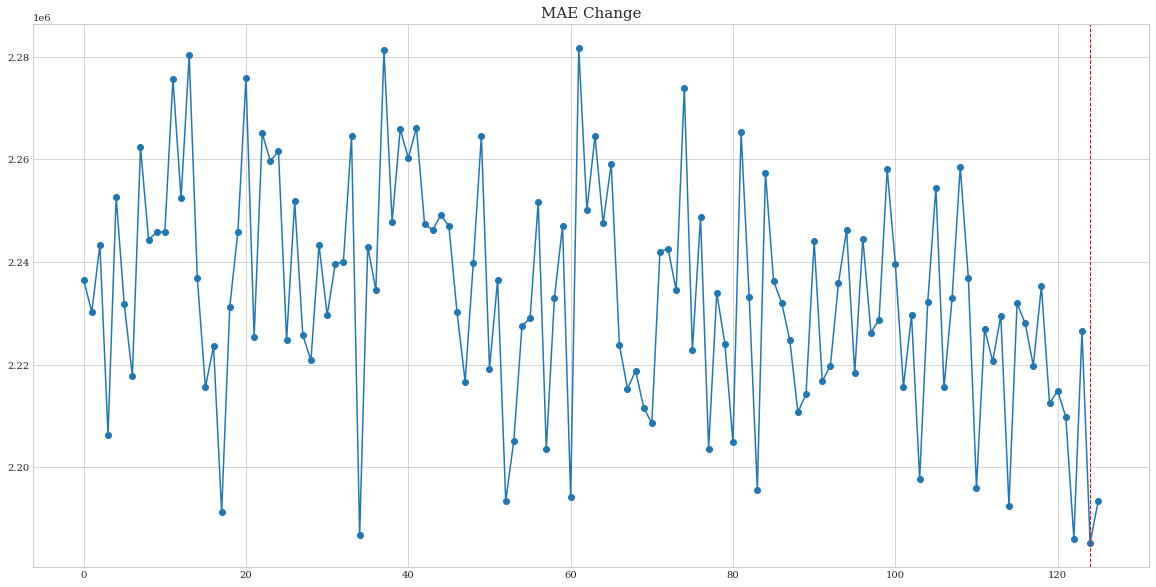

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [48]:
selected_features_shapeffects_09_01

['ID_metro',
 'ID_railroad_station_avto',
 'basketball_km',
 'build_year',
 'cafe_avg_price_1500',
 'cafe_avg_price_5000',
 'cafe_count_5000_price_500',
 'cafe_sum_1000_max_price_avg',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_5000_min_price_avg',
 'cemetery_km',
 'church_count_1000',
 'floor',
 'full_sq',
 'hospital_beds_raion',
 'kindergarten_km',
 'kitch_sq',
 'leisure_count_500',
 'life_sq',
 'max_floor',
 'metro_min_avto',
 'mosque_km',
 'num_room',
 'park_km',
 'prom_part_1000',
 'prom_part_3000',
 'state',
 'theater_km',
 'trc_count_5000',
 'trc_sqm_1000',
 'trc_sqm_2000',
 'university_km',
 'water_treatment_km']

In [49]:
dict_results_shapeffects_09_01 = {'rmse':[], 'mae':[], 'r2':[]}

In [50]:
X_test_shapeffects = X_test[selected_features_shapeffects_09_01]
X_train_shapeffects= X_train[selected_features_shapeffects_09_01]
X_val_shapeffects = X_val[selected_features_shapeffects_09_01]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_09_01["r2"].append(test_results["R2"])
    dict_results_shapeffects_09_01["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_09_01["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [51]:
results_shapeffects_09_01_df = pd.DataFrame(dict_results_shapeffects_09_01)
mean_shapeffects_09_01_test = results_shapeffects_09_01_df.mean()
std_shapeffects_09_01_test = results_shapeffects_09_01_df.std()
max_shapeffects_09_01_test = results_shapeffects_09_01_df.max()
min_shapeffects_09_01_test = results_shapeffects_09_01_df.min()

In [52]:
mean_shapeffects_09_01_test, std_shapeffects_09_01_test, max_shapeffects_09_01_test, min_shapeffects_09_01_test

(rmse    4.229112e+06
 mae     2.567351e+06
 r2      6.478965e-01
 dtype: float64,
 rmse    70207.981992
 mae     22193.892023
 r2          0.011653
 dtype: float64,
 rmse    4.374261e+06
 mae     2.604393e+06
 r2      6.833841e-01
 dtype: float64,
 rmse    4.010874e+06
 mae     2.507759e+06
 r2      6.234142e-01
 dtype: float64)

## SHAPEffects 0.95-0.05

In [53]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_095_005 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 0, 0.05, 0.95)
selected_features_shapeffects_095_005 = sorted(list(selected_features_shapeffects_095_005))


Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	54 features have been removed
	 ['area_m', 'raion_popul', 'green_zone_part', 'preschool_education_centers_raion', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'shopping_centers_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'full_all', 'female_f', 'young_male', 'young_female', 'ekder_male', '0_6_male', '7_14_male', '0_17_all', '0_17_male', '16_29_male', '16_29_female', 'build_count_frame', 'build_count_mix', 'big_road1_1line', 'ID_bus_terminal', 'cafe_count_500_price_1500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'church_count_500', 'mosque_count_500', 'market_count_500', 'cafe_count_1000_price_500', 'mosque_count_1000', 'cafe_count_1500_na_price', 'cafe_count_1500_price

	Selecting features
	1 features have been removed
	 ['green_zone_km']
	128 features left

Iteration 36
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['railroad_station_avto_km']
	127 features left

Iteration 37
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['sport_count_5000']
	126 features left

Iteration 38
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['church_count_1000']
	125 features left

Iteration 39
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_count_1000_price_1000']
	124 features left

Iteration 40
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['office_count_1500']
	123 features left

Iteration 41
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been remov


Iteration 88
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['green_part_2000']
	75 features left

Iteration 89
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['mosque_km']
	74 features left

Iteration 90
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['power_transmission_line_km']
	73 features left

Iteration 91
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_count_5000_price_2500']
	72 features left

Iteration 92
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['cafe_count_1500']
	71 features left

Iteration 93
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['green_part_3000']
	70 features left

Iteration 94
	Clasifying residuals
	Giving weights to featu

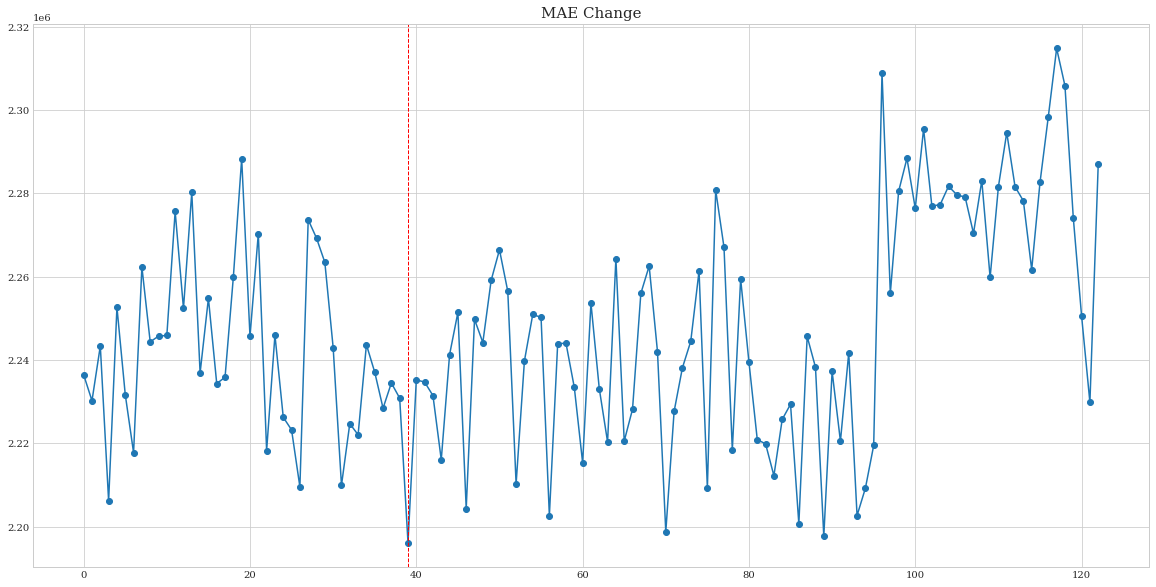

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [55]:
selected_features_shapeffects_095_005

['0_13_female',
 '7_14_female',
 'ID_big_road2',
 'ID_metro',
 'ID_railroad_station_avto',
 'ID_railroad_station_walk',
 'additional_education_km',
 'basketball_km',
 'big_church_count_1000',
 'big_church_km',
 'big_market_km',
 'big_road1_km',
 'big_road2_km',
 'build_count_panel',
 'build_year',
 'bus_terminal_avto_km',
 'cafe_avg_price_1000',
 'cafe_avg_price_1500',
 'cafe_avg_price_2000',
 'cafe_avg_price_500',
 'cafe_avg_price_5000',
 'cafe_count_1000',
 'cafe_count_1000_price_high',
 'cafe_count_1500',
 'cafe_count_2000',
 'cafe_count_2000_price_1500',
 'cafe_count_2000_price_4000',
 'cafe_count_2000_price_500',
 'cafe_count_3000',
 'cafe_count_3000_na_price',
 'cafe_count_3000_price_4000',
 'cafe_count_3000_price_500',
 'cafe_count_500',
 'cafe_count_5000_na_price',
 'cafe_count_5000_price_1000',
 'cafe_count_5000_price_1500',
 'cafe_count_5000_price_2500',
 'cafe_count_5000_price_500',
 'cafe_count_500_price_2500',
 'cafe_sum_1000_max_price_avg',
 'cafe_sum_1000_min_price_avg',

In [56]:
dict_results_shapeffects_095_005 = {'rmse':[], 'mae':[], 'r2':[]}

In [57]:
X_test_shapeffects = X_test[selected_features_shapeffects_095_005]
X_train_shapeffects= X_train[selected_features_shapeffects_095_005]
X_val_shapeffects = X_val[selected_features_shapeffects_095_005]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_095_005["r2"].append(test_results["R2"])
    dict_results_shapeffects_095_005["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_095_005["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [58]:
results_shapeffects_095_005_df = pd.DataFrame(dict_results_shapeffects_095_005)
mean_shapeffects_095_005_test = results_shapeffects_095_005_df.mean()
std_shapeffects_095_005_test = results_shapeffects_095_005_df.std()
max_shapeffects_095_005_test = results_shapeffects_095_005_df.max()
min_shapeffects_095_005_test = results_shapeffects_095_005_df.min()

In [59]:
mean_shapeffects_095_005_test, std_shapeffects_095_005_test, max_shapeffects_095_005_test, min_shapeffects_095_005_test

(rmse    4.404562e+06
 mae     2.639286e+06
 r2      6.180299e-01
 dtype: float64,
 rmse    87830.888087
 mae     27296.897131
 r2          0.015208
 dtype: float64,
 rmse    4.574899e+06
 mae     2.718269e+06
 r2      6.551884e-01
 dtype: float64,
 rmse    4.185657e+06
 mae     2.573535e+06
 r2      5.880756e-01
 dtype: float64)

## PowerSHAP

In [60]:
selector = PowerShap(
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123),
    power_iterations=10,automatic=True, limit_automatic=10,verbose=True,target_col=target_col,index_col=Index_col,
)
selector.fit(current_db_train_val[list(selected_columns)], current_db_train_val[target_col])

Starting powershap
Automatic mode enabled: Finding the minimal required powershap iterations for significance of 0.01.



10 iterations were already sufficient as only 6 iterations were required for the current  power_alpha = 0.01.
Done!


PowerShap(model=<catboost.core.CatBoostRegressor object at 0x0000028CAB2A1790>,
          verbose=True)

In [61]:
t = selector._processed_shaps_df
selected_features_powershap = t[(t.p_value<0.01)].index.values
selected_features_powershap

array(['full_sq', 'state', 'life_sq', 'build_year', 'kitch_sq',
       'max_floor', 'floor'], dtype=object)

In [62]:
selected_features_powershap = sorted(selected_features_powershap)

In [24]:
selected_features_powershap = sorted(['full_sq', 'state', 'life_sq', 'build_year', 'kitch_sq',
       'max_floor', 'floor'])

In [25]:
dict_results_powershap = {'rmse':[], 'mae':[], 'r2':[]}

In [26]:
X_test_powershap = X_test[selected_features_powershap]
X_train_powershap = X_train[selected_features_powershap]
X_val_powershap = X_val[selected_features_powershap]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_powershap, y_train,
        eval_set=(X_val_powershap, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_powershap), print_bool=False)
    
    dict_results_powershap["r2"].append(test_results["R2"])
    dict_results_powershap["rmse"].append(test_results["RMSE"])
    dict_results_powershap["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [27]:
results_powershap_df = pd.DataFrame(dict_results_powershap)
mean_powershap_test = results_powershap_df.mean()
std_powershap_test = results_powershap_df.std()
max_powershap_test = results_powershap_df.max()
min_powershap_test = results_powershap_df.min()

In [28]:
mean_powershap_test, std_powershap_test, max_powershap_test, min_powershap_test

(rmse    4.899156e+06
 mae     2.971573e+06
 r2      5.275302e-01
 dtype: float64,
 rmse    65839.230527
 mae     22573.881330
 r2          0.012668
 dtype: float64,
 rmse    5.002302e+06
 mae     3.013116e+06
 r2      5.519444e-01
 dtype: float64,
 rmse    4.771321e+06
 mae     2.922489e+06
 r2      5.075133e-01
 dtype: float64)

## BorutaSHAP

In [67]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=X_train_val, y=y_train_val, sample=False,
                        train_or_test = 'test', normalize=True,verbose=True)


8 attributes confirmed important: ['build_year', 'life_sq', 'max_floor', 'num_room', 'state', 'kitch_sq', 'full_sq', 'floor']
256 attributes confirmed unimportant: ['raion_build_count_with_builddate_info', 'prom_part_2000', 'market_count_2000', 'public_healthcare_km', 'area_m', 'cafe_sum_1000_min_price_avg', 'preschool_education_centers_raion', 'cafe_count_1500_price_4000', 'office_sqm_2000', 'metro_km_walk', 'work_female', 'shopping_centers_raion', 'green_part_1500', 'trc_count_500', '0_13_male', 'water_1line', 'build_count_brick', 'trc_sqm_5000', 'cafe_sum_1500_max_price_avg', 'church_count_5000', '0_6_all', 'railroad_km', 'cafe_count_1500_price_2500', 'oil_chemistry_raion', 'prom_part_1500', 'cafe_count_1500_na_price', 'school_km', 'nuclear_reactor_km', 'big_church_count_1000', 'office_sqm_1500', 'green_part_5000', 'trc_count_2000', 'cafe_count_1000_price_high', 'office_count_1500', 'cafe_sum_2000_max_price_avg', '0_17_all', 'water_treatment_km', 'office_count_1000', 'children_scho

In [68]:
subset = Feature_Selector.Subset()
selected_features_borutashap = sorted(subset.columns.values)
selected_features_borutashap

['build_year',
 'floor',
 'full_sq',
 'kitch_sq',
 'life_sq',
 'max_floor',
 'num_room',
 'state']

In [29]:
selected_features_borutashap = sorted(['build_year', 'life_sq', 'max_floor', 'num_room', 'state', 'kitch_sq', 'full_sq', 'floor']) 

In [30]:
dict_results_borutashap = {'rmse':[], 'mae':[], 'r2':[]}

In [31]:
X_test_borutashap = X_test[selected_features_borutashap]
X_train_borutashap = X_train[selected_features_borutashap]
X_val_borutashap = X_val[selected_features_borutashap]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_borutashap, y_train,
        eval_set=(X_val_borutashap, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_borutashap), print_bool=False)
    
    dict_results_borutashap["r2"].append(test_results["R2"])
    dict_results_borutashap["rmse"].append(test_results["RMSE"])
    dict_results_borutashap["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [32]:
results_borutashap_df = pd.DataFrame(dict_results_borutashap)
mean_borutashap_test = results_borutashap_df.mean()
std_borutashap_test = results_borutashap_df.std()
max_borutashap_test = results_borutashap_df.max()
min_borutashap_test = results_borutashap_df.min()

In [33]:
mean_borutashap_test, std_borutashap_test, max_borutashap_test, min_borutashap_test

(rmse    4.907157e+06
 mae     2.977164e+06
 r2      5.259893e-01
 dtype: float64,
 rmse    64571.758424
 mae     17471.113422
 r2          0.012475
 dtype: float64,
 rmse    5.054683e+06
 mae     3.007671e+06
 r2      5.507740e-01
 dtype: float64,
 rmse    4.777549e+06
 mae     2.942027e+06
 r2      4.971454e-01
 dtype: float64)

## Shapicant

In [73]:
# LightGBM in RandomForest-like mode (with rows subsampling), without columns subsampling
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)


# This is the class (not its instance) of SHAP's TreeExplainer
explainer_type = shap.TreeExplainer

# Use PandasSelector with 100 iterations
selector = shapicant.PandasSelector(model, explainer_type, random_state=42)

# Run the feature selection
# If we provide a validation set, SHAP values are computed on it, otherwise they are computed on the training set
# We can also provide additional parameters to the underlying estimator's fit method through estimator_params
selector.fit(X_train, y_train, X_validation=X_val)#, estimator_params={"categorical_feature": None})

# Just get the features list
selected_features = selector.get_features()

# We can also get the p-values as pandas Series
p_values = selector.p_values_

selected_features_shapicant = sorted(np.array(selected_features))

Computing null SHAP values: 100%|████████████████████████████████████████████████████| 100/100 [09:29<00:00,  5.70s/it]


In [74]:
selected_features_shapicant

['0_13_female',
 '0_17_female',
 '0_6_all',
 'build_year',
 'cafe_count_1000_price_2500',
 'cafe_sum_5000_max_price_avg',
 'culture_objects_top_25_raion',
 'full_sq',
 'max_floor',
 'num_room',
 'office_sqm_5000',
 'product_type',
 'school_education_centers_raion',
 'state',
 'young_all']

In [34]:
selected_features_shapicant = sorted(['0_13_female',
 '0_17_female',
 '0_6_all',
 'build_year',
 'cafe_count_1000_price_2500',
 'cafe_sum_5000_max_price_avg',
 'culture_objects_top_25_raion',
 'full_sq',
 'max_floor',
 'num_room',
 'office_sqm_5000',
 'product_type',
 'school_education_centers_raion',
 'state',
 'young_all'])

In [35]:
dict_results_shapicant = {'rmse':[], 'mae':[], 'r2':[]}

In [36]:
X_test_shapicant = X_test[selected_features_shapicant]
X_train_shapicant= X_train[selected_features_shapicant]
X_val_shapicant = X_val[selected_features_shapicant]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapicant, y_train,
        eval_set=(X_val_shapicant, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapicant), print_bool=False)
    
    dict_results_shapicant["r2"].append(test_results["R2"])
    dict_results_shapicant["rmse"].append(test_results["RMSE"])
    dict_results_shapicant["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [37]:
results_shapicant_df = pd.DataFrame(dict_results_shapicant)
mean_shapicant_test = results_shapicant_df.mean()
std_shapicant_test = results_shapicant_df.std()
max_shapicant_test = results_shapicant_df.max()
min_shapicant_test = results_shapicant_df.min()

In [38]:
mean_shapicant_test, std_shapicant_test, max_shapicant_test, min_shapicant_test

(rmse    4.356884e+06
 mae     2.658154e+06
 r2      6.262794e-01
 dtype: float64,
 rmse    79110.835347
 mae     34253.244519
 r2          0.013622
 dtype: float64,
 rmse    4.593221e+06
 mae     2.737997e+06
 r2      6.474845e-01
 dtype: float64,
 rmse    4.232157e+06
 mae     2.570745e+06
 r2      5.847694e-01
 dtype: float64)

# Results

In [79]:
nombres = ['PowerSHAP', 'BorutaSHAP', 'Shapicant', 'SHAPEffects_075_025', 'SHAPEffects_08_02', 'SHAPEffects_085_015', 'SHAPEffects_09_01', 'SHAPEffects_095_005']

## MAE

In [80]:
resultados_mae_mean = [mean_powershap_test['mae'], mean_borutashap_test['mae'], mean_shapicant_test['mae'], mean_shapeffects_075_025_test['mae'], mean_shapeffects_08_02_test['mae'], mean_shapeffects_085_015_test['mae'], mean_shapeffects_09_01_test['mae'], mean_shapeffects_095_005_test['mae']]
resultados_mae_std = [std_powershap_test['mae'], std_borutashap_test['mae'], std_shapicant_test['mae'], std_shapeffects_075_025_test['mae'], std_shapeffects_08_02_test['mae'], std_shapeffects_085_015_test['mae'], std_shapeffects_09_01_test['mae'], std_shapeffects_095_005_test['mae']]
resultados_mae_max = [max_powershap_test['mae'], max_borutashap_test['mae'], max_shapicant_test['mae'], max_shapeffects_075_025_test['mae'], max_shapeffects_08_02_test['mae'], max_shapeffects_085_015_test['mae'], max_shapeffects_09_01_test['mae'], max_shapeffects_095_005_test['mae']]
resultados_mae_min = [min_powershap_test['mae'], min_borutashap_test['mae'], min_shapicant_test['mae'], min_shapeffects_075_025_test['mae'], min_shapeffects_08_02_test['mae'], min_shapeffects_085_015_test['mae'], min_shapeffects_09_01_test['mae'], min_shapeffects_095_005_test['mae']]

(2400000.0, 3200000.0)

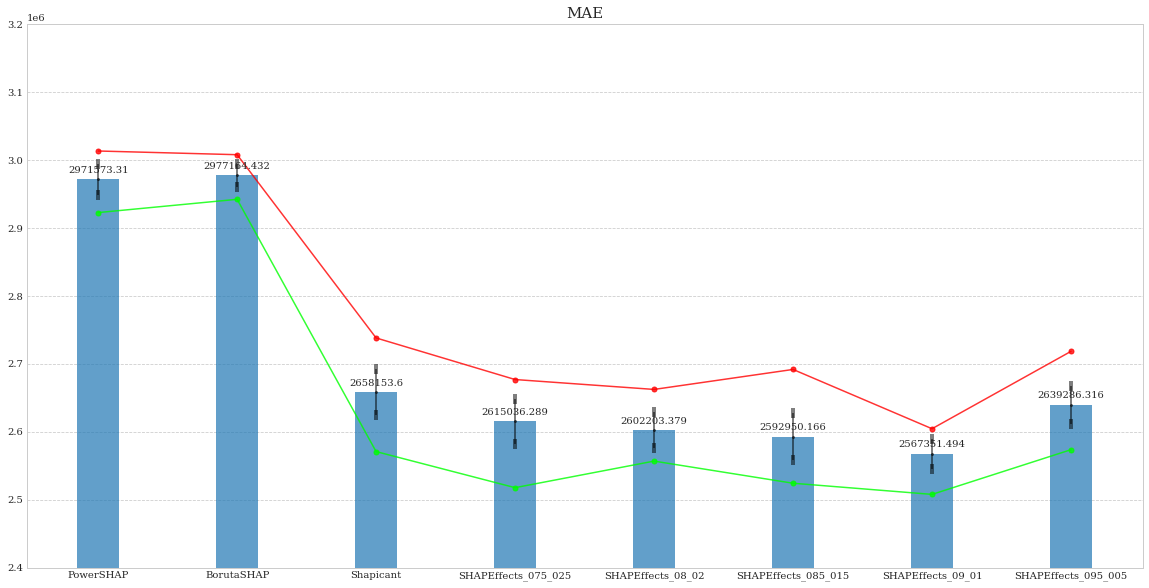

In [91]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_mae_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_mae_mean, resultados_mae_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_mae_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_mae_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("MAE")
ax.title.set_size(15)
for index,data in enumerate(resultados_mae_mean):
    ax.text(x=index , y =data+10000 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([2.400000e+06, 3.200000e+06])


## RMSE

In [82]:
resultados_rmse_mean = [mean_powershap_test['rmse'], mean_borutashap_test['rmse'], mean_shapicant_test['rmse'], mean_shapeffects_075_025_test['rmse'], mean_shapeffects_08_02_test['rmse'], mean_shapeffects_085_015_test['rmse'], mean_shapeffects_09_01_test['rmse'], mean_shapeffects_095_005_test['rmse']]
resultados_rmse_std = [std_powershap_test['rmse'], std_borutashap_test['rmse'], std_shapicant_test['rmse'], std_shapeffects_075_025_test['rmse'], std_shapeffects_08_02_test['rmse'], std_shapeffects_085_015_test['rmse'], std_shapeffects_09_01_test['rmse'], std_shapeffects_095_005_test['rmse']]
resultados_rmse_max = [max_powershap_test['rmse'], max_borutashap_test['rmse'], max_shapicant_test['rmse'], max_shapeffects_075_025_test['rmse'], max_shapeffects_08_02_test['rmse'], max_shapeffects_085_015_test['rmse'], max_shapeffects_09_01_test['rmse'], max_shapeffects_095_005_test['rmse']]
resultados_rmse_min = [min_powershap_test['rmse'], min_borutashap_test['rmse'], min_shapicant_test['rmse'], min_shapeffects_075_025_test['rmse'], min_shapeffects_08_02_test['rmse'], min_shapeffects_085_015_test['rmse'], min_shapeffects_09_01_test['rmse'], min_shapeffects_095_005_test['rmse']]

(3800000.0, 5250000.0)

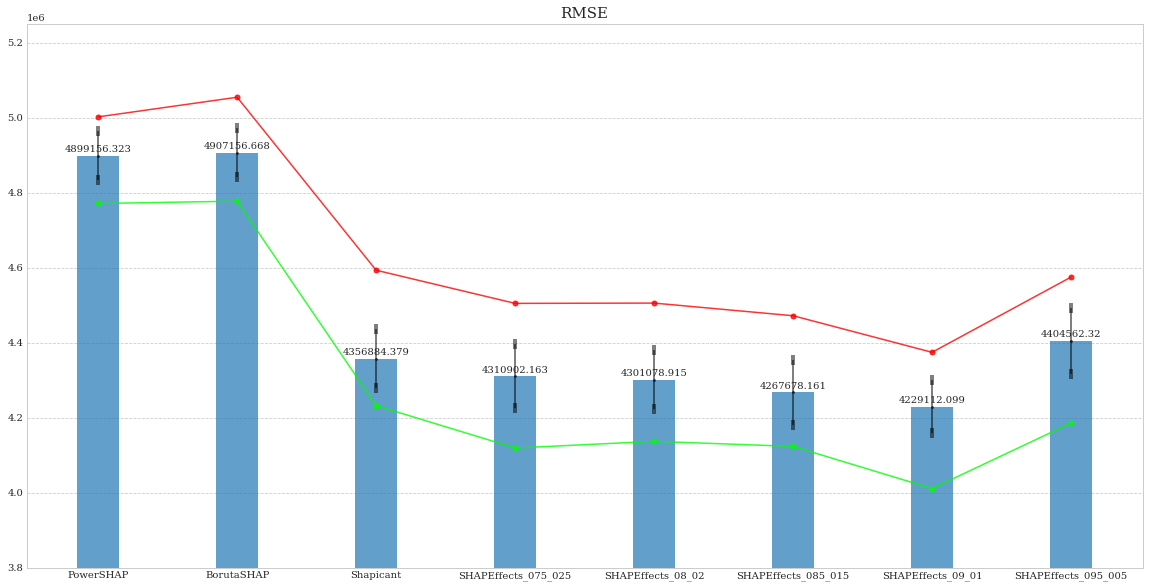

In [90]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_rmse_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_rmse_mean, resultados_rmse_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_rmse_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_rmse_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("RMSE")
ax.title.set_size(15)
for index,data in enumerate(resultados_rmse_mean):
    ax.text(x=index , y =data+10000 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([3.800000e+06, 5.250000e+06])

## R2

In [84]:
resultados_r2_mean = [mean_powershap_test['r2'], mean_borutashap_test['r2'], mean_shapicant_test['r2'], mean_shapeffects_075_025_test['r2'], mean_shapeffects_08_02_test['r2'], mean_shapeffects_085_015_test['r2'], mean_shapeffects_09_01_test['r2'], mean_shapeffects_095_005_test['r2']]
resultados_r2_std = [std_powershap_test['r2'], std_borutashap_test['r2'], std_shapicant_test['r2'], std_shapeffects_075_025_test['r2'], std_shapeffects_08_02_test['r2'], std_shapeffects_085_015_test['r2'], std_shapeffects_09_01_test['r2'], std_shapeffects_095_005_test['r2']]
resultados_r2_max = [max_powershap_test['r2'], max_borutashap_test['r2'], max_shapicant_test['r2'], max_shapeffects_075_025_test['r2'], max_shapeffects_08_02_test['r2'], max_shapeffects_085_015_test['r2'], max_shapeffects_09_01_test['r2'], max_shapeffects_095_005_test['r2']]
resultados_r2_min = [min_powershap_test['r2'], min_borutashap_test['r2'], min_shapicant_test['r2'], min_shapeffects_075_025_test['r2'], min_shapeffects_08_02_test['r2'], min_shapeffects_085_015_test['r2'], min_shapeffects_09_01_test['r2'], min_shapeffects_095_005_test['r2']]

In [85]:
resultados_r2_max, resultados_r2_min

([0.5519443656915886,
  0.550774006410898,
  0.6474844855744661,
  0.6660812271419935,
  0.6631885161105029,
  0.6653886480651438,
  0.6833841097551947,
  0.6551884306354545],
 [0.5075133468059938,
  0.49714541451257044,
  0.5847693642001419,
  0.6005970317735816,
  0.6004616375000602,
  0.6064268312489558,
  0.6234141547113491,
  0.5880755599844517])

(0.45, 0.75)

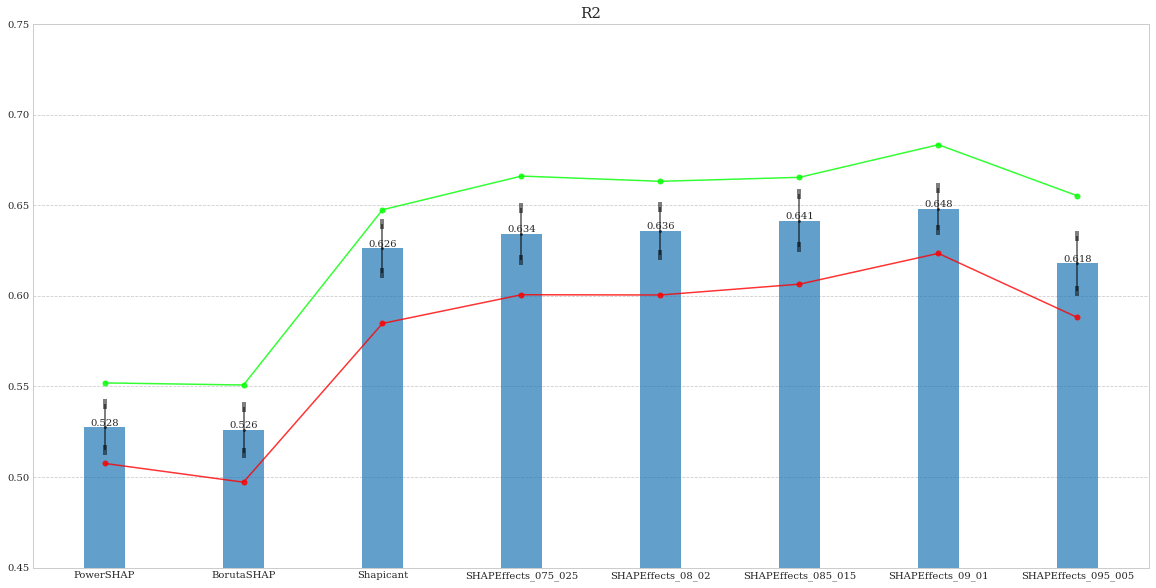

In [95]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_r2_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_r2_mean, resultados_r2_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_r2_max, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_r2_min, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False,)
ax.title.set_text("R2")
ax.title.set_size(15)
for index,data in enumerate(resultados_r2_mean):
    ax.text(x=index , y =data+0.001 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0.45, 0.75])

## Number of variables

In [87]:
n_var = [len(selected_features_powershap), len(selected_features_borutashap), len(selected_features_shapicant), len(selected_features_shapeffects_075_025), len(selected_features_shapeffects_08_02), len(selected_features_shapeffects_085_015), len(selected_features_shapeffects_09_01), len(selected_features_shapeffects_095_005)]

(0.0, 130.0)

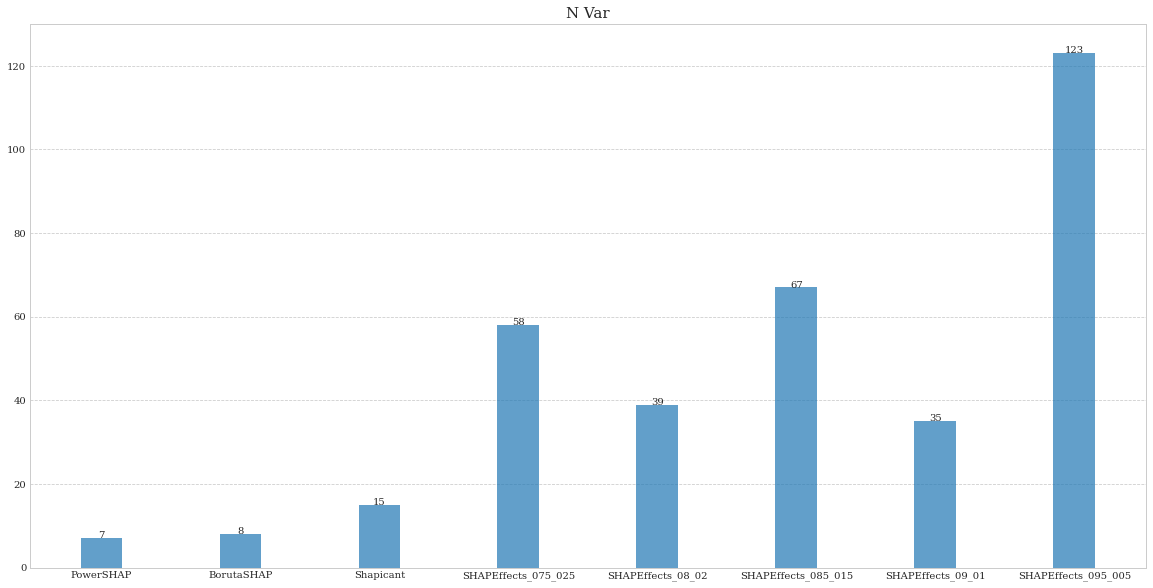

In [88]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
bars = ax.bar(nombres, n_var, alpha = 0.7, width=0.3)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("N Var")
ax.title.set_size(15)
for index,data in enumerate(n_var):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0, 130])